In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath('..'))

In [36]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use('../plotting/style_sheet.mplstyle')
from toy_rnn.dataset import Dataset
from plotting import plotting_utils
import sklearn
from toy_rnn.dataset import Dataset
from toy_rnn.rnn import MultiSetRNN
from synthetic_data.gaussian_process import GPSpikeGenerator

In [86]:
# Configuration
LATENT_DIM = 3
LATENT_TIMESCALE = 0.5
DT = 0.1
MEDIAN_FIRING_RATE = 20.0
NUM_NEURONS = 50

In [87]:
# Dataset, responsible for generating "synthetic" data 
data_generator = GPSpikeGenerator(
    latent_dim=LATENT_DIM,
    latent_timescale=LATENT_TIMESCALE,
    kernel_type="rbf",
    dt=DT,
    median_firing_rate=MEDIAN_FIRING_RATE,
    num_neurons=NUM_NEURONS,
)

In [88]:
trial = data_generator.sample(total_time=100.0)

(time, latents, spike_counts, spike_times, spike_unit_ids) = trial

Checking distribution of normalized logrates: mean=-0.00, std=1.05
Checking distribution of lognormalize rates: median=20.04, std=7.79


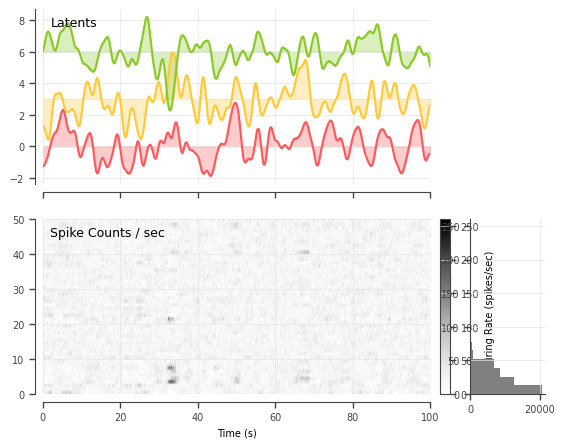

In [89]:
# Plot latents and alinged-spike-count PCs
fig, ax = plt.subplots(2,1, figsize=(5,5), sharex=True)
for l in range(latents.shape[1]):
    line = ax[0].plot(time, 3*l + latents[:, l])
    ax[0].fill_between(time, 3*l + latents[:, l], 3*l, alpha=0.3, color = line[0].get_color())
ax[0].text(0.02, 0.9, "Latents", transform=ax[0].transAxes)
ax[0].set_prop_cycle(None)  # reset color cycle
# for l in range(pcs.shape[1]):
    # ax[0].plot(time, 2*l + pcs[:, l], alpha=0.5)

# Plot spike counts
spike_rates = spike_counts / DT  # convert to firing rates
im = ax[1].imshow(spike_rates.T, aspect='auto', cmap='Greys', origin='lower', extent=[time[0], time[-1], 0, spike_rates.shape[1]])
ax[1].text(0.02, 0.9, "Spike Counts / sec", transform=ax[1].transAxes)
ax[1].set_xlabel("Time (s)")
# add colorbar and scale its axis by dt to convert to firing rates
# add new axis for colorbar
cax = fig.add_axes([0.92, 0.11, 0.02, 0.35])
cbar = fig.colorbar(im, ax=ax[1], cax=cax)
cbar.ax.set_ylabel("Firing Rate (spikes/sec)")

# add a new axis on the side of the color bar where i plot a histogram of spike rates and share axis with the color bar
hist_ax = fig.add_axes([0.98, 0.11, 0.15, 0.35], sharey=cax)
# make a rotated histogram
hist_ax.hist(spike_rates.flatten(), bins=20, orientation='horizontal', color='gray')
plotting_utils.outset_axes(ax[0])
plotting_utils.outset_axes(ax[1])

In [90]:
def fit_pcs(data, n_pcs=None, ground_truth=None,):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_pcs)
    data_centered = data - np.mean(data, axis=0, keepdims=True)
    pcs = pca.fit_transform(data_centered)
    if ground_truth is not None:
        from sklearn.linear_model import LinearRegression
        reg = LinearRegression(fit_intercept=False).fit(pcs, ground_truth)
        pcs_aligned = reg.predict(pcs)
        return pcs_aligned
    return pcs

In [61]:
N_PCS = 3 
pcs = fit_pcs(spike_counts, n_pcs=N_PCS, ground_truth=latents)
r_sq = sklearn.metrics.r2_score(latents[:, :N_PCS], pcs)
print(f'Variance explained by first {N_PCS} PCs: {r_sq:.3f}')

Variance explained by first 3 PCs: 0.764


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Using device: {device}")

# 1. Init Data
dataset = Dataset(
    num_sets=NUM_SETS, 
    num_neurons=NUM_NEURONS, 
    latent_dim=LATENT_DIM, 
    latent_timescale=LATENT_TIMESCALE, 
    dt=DT, 
    trial_duration=TRIAL_DURATION)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

# 2. Init Model
model = MultiSetRNN(
    num_sets=NUM_SETS,
    input_size=NUM_NEURONS,    # Input is spike counts
    hidden_size=HIDDEN_SIZE,   # Size of LSTM hidden state
    latent_dim=LATENT_DIM      # Output target dimension
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 3. Training Loop
# Note: Since it's an IterableDataset with 'while True', you need a break condition
max_steps = 1000

for step, batch in enumerate(dataloader):
    if step >= max_steps:
        break
    
    # Move data to device
    batch = {k: v.to(device) for k, v in batch.items()}

    # Unpack data
    x = batch["spike_counts"]  # (Batch, Time, Neurons)
    y = batch["latents"]       # (Batch, Time, Latents)
    indices = batch["dataset_idx"] # (Batch)
    
    # Forward pass
    # We pass both the data AND the indices so the model knows how to route
    predictions = model(x, indices)
    
    # Loss calculation
    loss = criterion(predictions, y)
    
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")

(array([5.980e+02, 1.224e+03, 1.198e+03, 1.062e+03, 9.670e+02, 7.250e+02,
        5.580e+02, 4.910e+02, 4.050e+02, 3.590e+02, 2.830e+02, 2.410e+02,
        2.130e+02, 1.820e+02, 1.680e+02, 1.160e+02, 1.040e+02, 1.200e+02,
        8.700e+01, 9.200e+01, 8.600e+01, 6.600e+01, 5.600e+01, 4.600e+01,
        5.400e+01, 5.000e+01, 3.600e+01, 3.200e+01, 3.200e+01, 2.600e+01,
        1.900e+01, 2.000e+01, 1.900e+01, 1.800e+01, 2.000e+01, 2.100e+01,
        2.100e+01, 1.300e+01, 1.000e+01, 1.000e+01, 1.400e+01, 9.000e+00,
        6.000e+00, 9.000e+00, 6.000e+00, 5.000e+00, 4.000e+00, 6.000e+00,
        5.000e+00, 4.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00, 6.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00, 5.000e+00, 1.000e+00, 7.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 5.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 2.000e+0

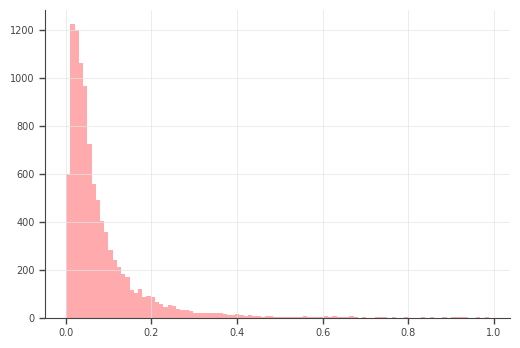

In [20]:
import numpy as np 
a = np.random.randn(10000)
ea = np.exp(a)


# plt.hist(ea, alpha=0.5, bins=1000)
plt.hist(np.tanh(ea / np.exp(3)), alpha=0.5, bins=100)